# Notebook showing a fast and efficient way to load Sentinel-2 L1C data into xarray

In [1]:
import glob
import os
import numpy as np

import pandas as pd
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap



import hvplot.xarray

import holoviews as hv
import holoviews.operation.datashader as hd
from holoviews import opts
hv.extension('bokeh')
#import geoviews
import datashader as ds
from datashader import transfer_functions as tf 
import colorcet as cc
import panel as pn
import panel.widgets as pnw
opts.defaults(
    opts.GridSpace(shared_xaxis=True, shared_yaxis=True),
    opts.Image(cmap='binary_r', width=800, height=700),
    opts.Labels(text_color='white', text_font_size='8pt', text_align='left', text_baseline='bottom'),
    opts.Path(color='white'),
    opts.Spread(width=900),
    opts.Overlay(show_legend=True))
# set the parameter for spectra extraction
import bokeh
pn.extension()

from s2driver import driver_S2_SAFE as S2
from s2driver import visual
import grstbx

import memory_profiler


%load_ext memory_profiler


opj = os.path.join


Set the path of the images you want to load, here is a example for the former (v3) and current (v4) image formatting 

In [2]:
imageSAFE = '/data/satellite/Sentinel-2/L1C/30SYJ/2021/01/05/S2A_MSIL1C_20210105T105441_N0500_R051_T30SYJ_20230405T044638.SAFE'


First, check the availbale bands:

In [3]:
S2.INFO

bandId            0     1      2    3      4      5      6    7           8   \
ESA              B01   B02    B03  B04    B05    B06    B07  B08         B8A   
EOREADER          CA  BLUE  GREEN  RED  VRE_1  VRE_2  VRE_3  NIR  NARROW_NIR   
Wavelength (nm)  443   490    560  665    705    740    783  842         865   
Band width (nm)   20    65     35   30     15     15     20  115          20   
Resolution (m)    60    10     10   10     20     20     20   10          20   

bandId            9            10      11      12  
ESA              B09          B10     B11     B12  
EOREADER          WV  SWIR_CIRRUS  SWIR_1  SWIR_2  
Wavelength (nm)  945         1375    1610    2190  
Band width (nm)   20           30      90     180  
Resolution (m)    60           60      20      20

Choose the bands to be loaded (fill the bandIds array up) and the resolution between 10, 20 and 60 m:

In [4]:
bandIds = [0,1,2,3,4,8,11,12]
bandIds = [1,2,3,4,11]
resolution=20


Create the s2driver objects for the selected images

In [5]:

l1c = S2.sentinel2_driver(imageSAFE,band_idx=bandIds,resolution=resolution)
ESAbands = l1c.INFO.loc['ESA']
ESAbands.values

array(['B02', 'B03', 'B04', 'B05', 'B11'], dtype=object)

In [6]:
l1c.INFO


bandId             1      2    3      4       11
ESA               B02    B03  B04    B05     B11
EOREADER         BLUE  GREEN  RED  VRE_1  SWIR_1
Wavelength (nm)   490    560  665    705    1610
Band width (nm)    65     35   30     15      90
Resolution (m)     10     10   10     20      20

Load band reflectances and get the *bands* xarray 


In [7]:
%time %memit l1c.load_bands(add_time=True)

/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


peak memory: 4819.88 MiB, increment: 4347.29 MiB
CPU times: user 2min 43s, sys: 18.8 s, total: 3min 2s
Wall time: 43.4 s


In [8]:
l1c.prod

<xarray.Dataset>
Dimensions:      (x: 5490, y: 5490, wl: 5, wl_hr: 1950)
Coordinates:
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 4.4e+06 4.4e+06 4.4e+06 ... 4.29e+06 4.29e+06
    spatial_ref  int64 0
  * wl           (wl) object 490 560 665 705 1610
  * wl_hr        (wl_hr) int64 400 401 402 403 404 ... 2345 2346 2347 2348 2349
    time         datetime64[ns] 2021-01-05T10:54:41
Data variables:
    bands        (wl, y, x) float32 0.109 0.1064 0.0996 ... 0.0031 0.0036 0.0038
    SRF          (wl, wl_hr) float64 nan nan nan nan nan ... nan nan nan nan nan
    wl_true      (wl) float64 492.7 559.9 664.6 704.1 1.614e+03
Attributes: (12/14)
    long_name:         BLUE GREEN RED VRE_1 SWIR_1
    constellation:     Sentinel-2
    constellation_id:  S2
    product_path:      /data/satellite/Sentinel-2/L1C/30SYJ/2021/01/05/S2A_MS...
    product_name:      S2A_MSIL1C_20210105T105441_N0500_R051_T30SYJ_20230405T...
    product_filename:  S2A_MSIL1C_20210105T105441_N0500_R051_T30SYJ_20230405T...
    ...                ...
    acquisition_date:  20210105T105441
    condensed_name:    20210105T105441_S2_T30SYJ_L1C_044638
    orbit_direction:   DESCENDING
    radiometry:        reflectance
    cloud_cover:       0.0
    wl_to_process:     [ 443  490  560  665  705  740  783  842  865 1610 2190]

# Plotting section
The MSI-Sentinel-2 instrument is composed of 12 detectors staggered in two different rows making a "switch" in viewng geometries along the image especially for the azimuth values. Here, we plot the solar and viewing zenith angles as well as the relative azimuth between Sun and sensor directions.
The sun viewing angle (SZA) is common to all the spectral bands.

Set 'reproject=True' to repoject raster into WGS 84 / Pseudo-Mercator for web mapping and visualization (e.g., OpenStreetMap). The EPSG code is 3857. 

In [9]:
h=grstbx.visual.view_spectral(l1c.prod.bands,reproject=True)

In [10]:
# h.colormaps = ['CET_D13', 'bky', 'CET_D1A','CET_CBL2','CET_L10','CET_C6s', 'kbc', 'blues_r', 'kb', 'rainbow', 'fire', 'kgy', 'bjy','gray' ]

In [11]:
h.visu()

Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[0, 1, 2, 3, 4], value=2)
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2021, ...], start=datetime.date(2021, 1, 5), value=datetime.date(2021, 1, 5))
                [1] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='CartoDark')
            [2] Row
                [0] Row
                    [0] Markdown(str)
                    [1] EditableRangeSlider(end=0.06, name='Range Slider', step=0.0001, value=(0, 0.02), width=300)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
        [2] HoloViews(DynamicMap, height=800, sizing_mode='fixed', width=1200)

In [12]:
geom_ = h.get_geom(h.aoi_stream,crs=l1c.prod.rio.crs)

Rtoa_clipped = l1c.prod.bands.rio.clip(geom_.geometry.values)

In [14]:
l1c.prod

<xarray.Dataset>
Dimensions:      (x: 5490, y: 5490, wl: 8, time: 1, wl_hr: 1950)
Coordinates:
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int64 0
  * wl           (wl) object 443 490 560 665 705 865 1610 2190
  * wl_hr        (wl_hr) int64 400 401 402 403 404 ... 2345 2346 2347 2348 2349
  * time         (time) datetime64[ns] 2022-07-31T10:36:29
Data variables:
    bands        (time, wl, y, x) float32 0.1422 0.1422 0.1431 ... nan nan nan
    SRF          (time, wl, wl_hr) float64 nan nan nan nan ... nan nan nan nan
    wl_true      (time, wl) float64 442.2 492.4 558.9 ... 1.61e+03 2.186e+03
Attributes: (12/14)
    long_name:         CA BLUE GREEN RED VRE_1 NARROW_NIR SWIR_1 SWIR_2
    constellation:     Sentinel-2
    constellation_id:  S2
    product_path:      /data/satellite/S2/L1C/S2B_MSIL1C_20220731T103629_N040...
    product_name:      S2B_MSIL1C_20220731T103629_N0400_R008_T31TFJ_20220731T...
    product_filename:  S2B_MSIL1C_20220731T103629_N0400_R008_T31TFJ_20220731T...
    ...                ...
    acquisition_date:  20220731T103629
    condensed_name:    20220731T103629_S2_T31TFJ_L1C_124834
    orbit_direction:   DESCENDING
    radiometry:        reflectance
    cloud_cover:       0.0
    wl_to_process:     [ 443  490  560  665  705  740  783  842  865 1610 2190]

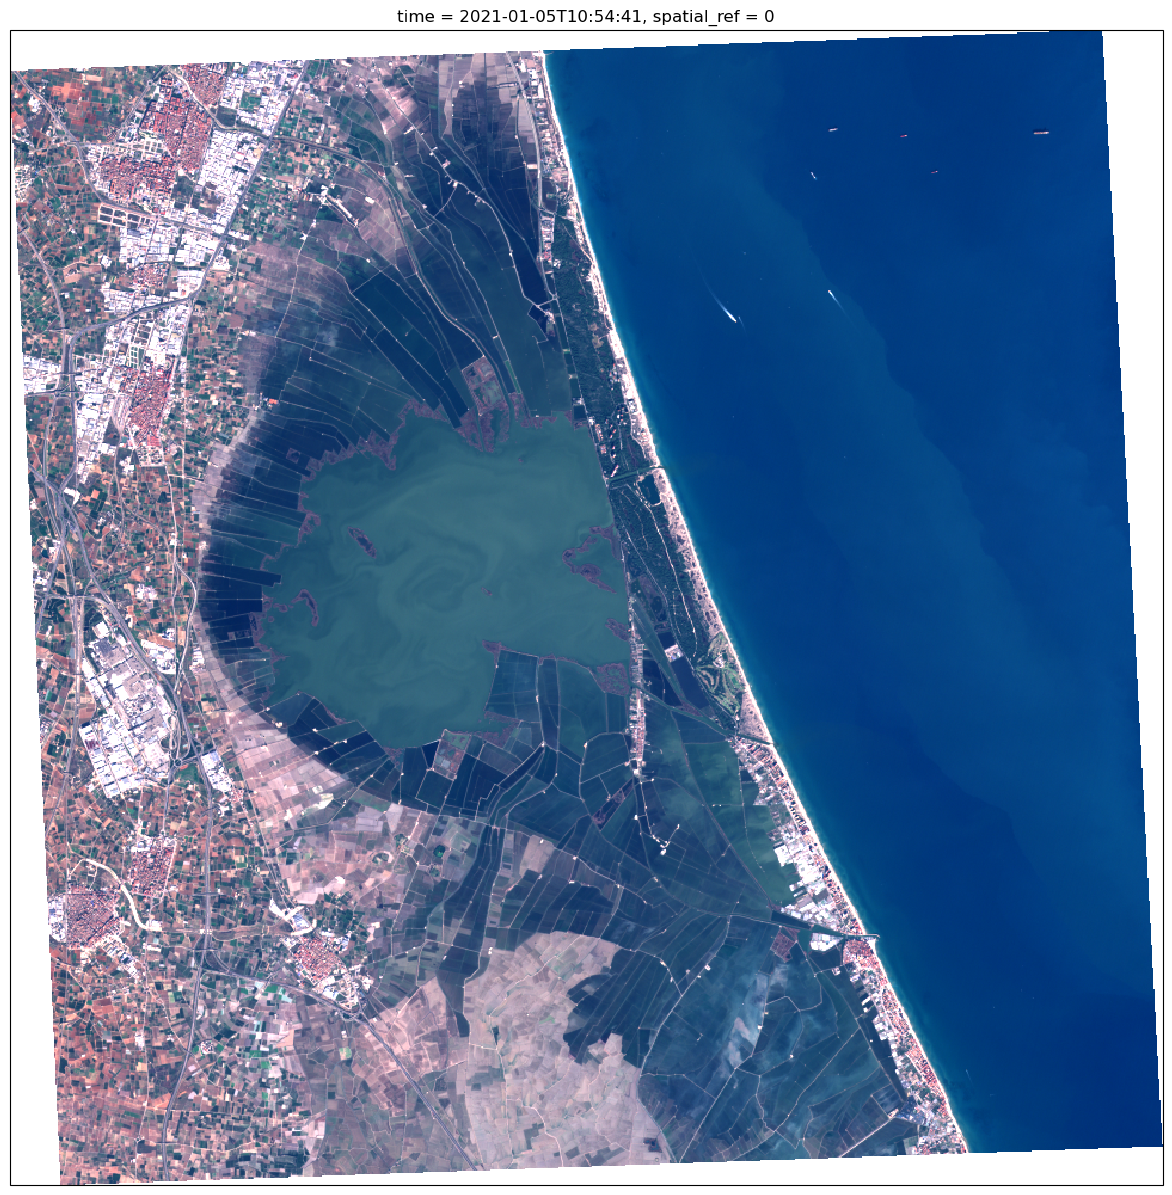

In [13]:

#%matplotlib ipympl
import cartopy.crs as ccrs
str_epsg = str(l1c.prod.bands.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

plt.figure(figsize=(15,15))
Rtoa_clipped.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

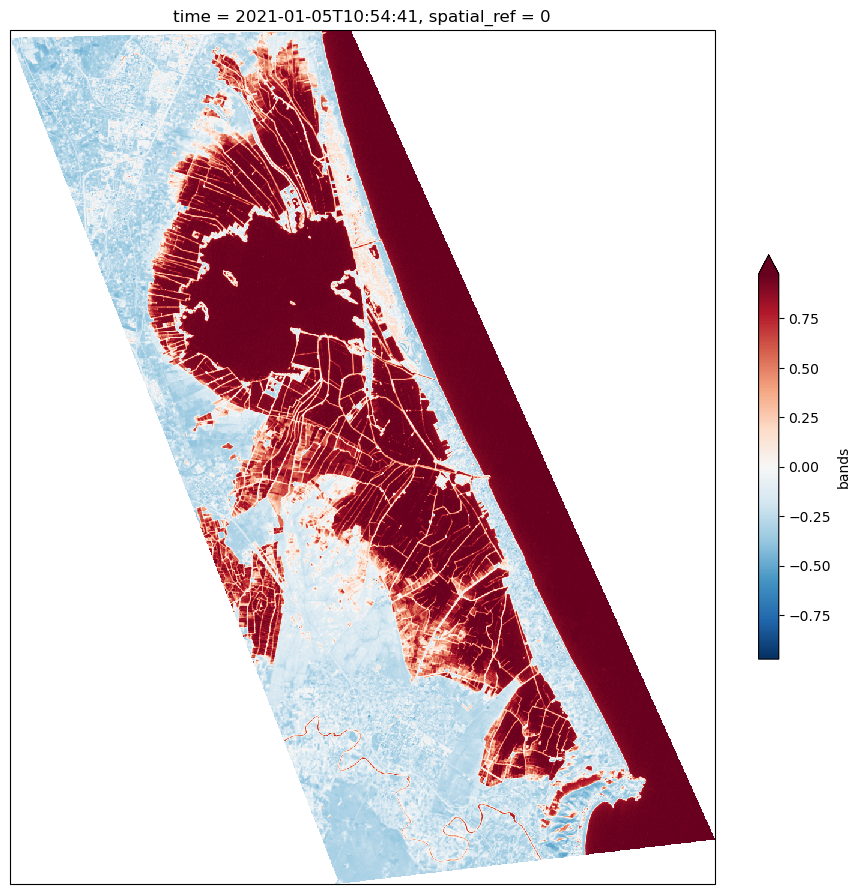

In [19]:

visible = Rtoa_clipped.sel(wl=490,method='nearest')
swir = Rtoa_clipped.sel(wl=1610,method='nearest')

ndwi_swir = (visible - swir) / (visible + swir)

fig = plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 2, 1, projection=proj)
ndwi_swir.plot.imshow(robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})

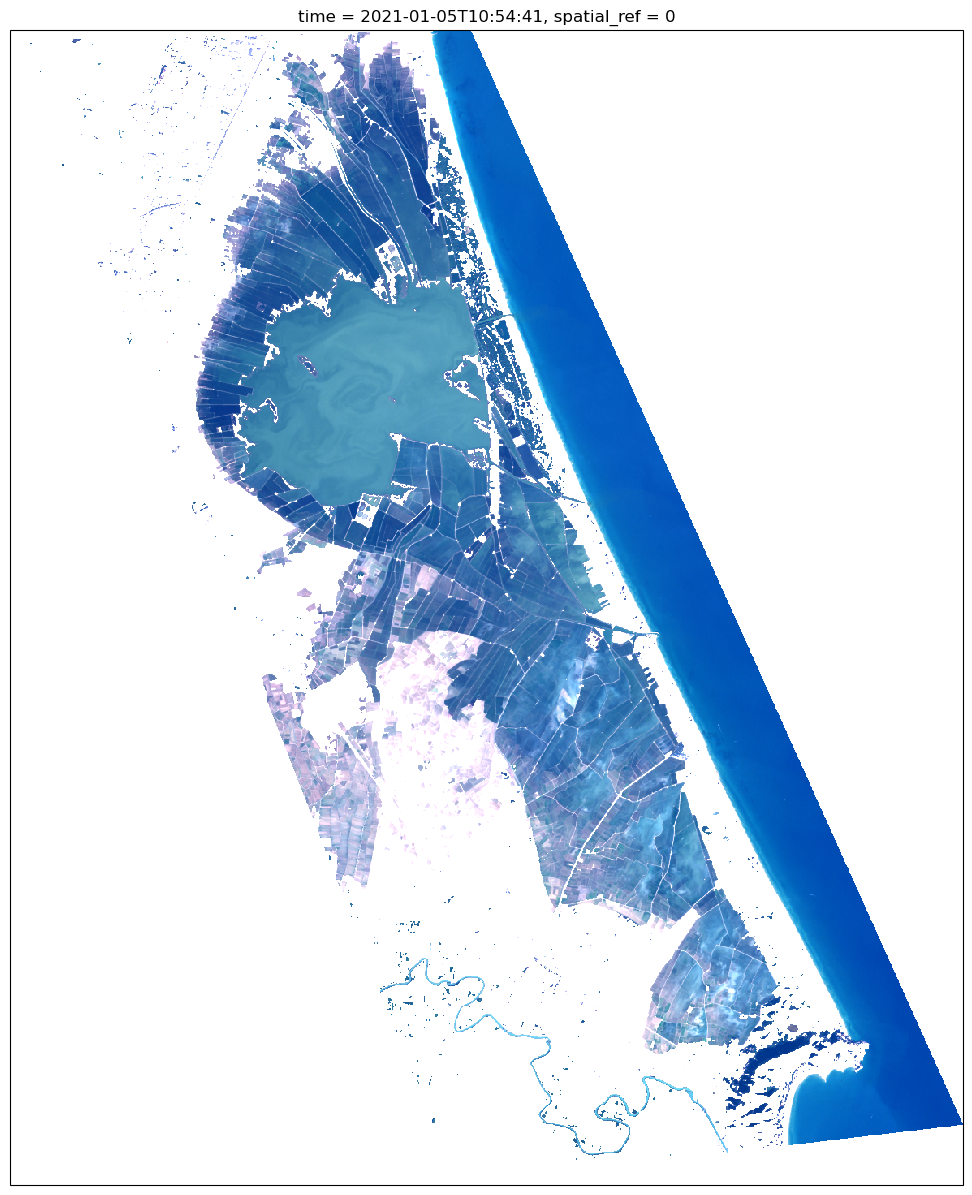

In [20]:
mask =  (ndwi_swir > 0) 
masked = Rtoa_clipped.where(mask)


plt.figure(figsize=(15,15))
masked.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

In [21]:
h=grstbx.visual.view_spectral(masked,reproject=True)
h.visu()

Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[0, 1, 2, 3, 4], value=2)
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2021, ...], start=datetime.date(2021, 1, 5), value=datetime.date(2021, 1, 5))
                [1] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='CartoDark')
            [2] Row
                [0] Row
                    [0] Markdown(str)
                    [1] EditableRangeSlider(end=0.06, name='Range Slider', step=0.0001, value=(0, 0.02), width=300)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
        [2] HoloViews(DynamicMap, height=800, sizing_mode='fixed', width=1200)